In [1]:
#https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/
#https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

from sklearn.cluster import KMeans
from keras.datasets import mnist
import os
import keras
#import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

import nets
#from evolutron.motifs import motif_extraction
from evolutron.templates import callback_templates as cb
from evolutron.extra_metrics import mean_cat_acc
from evolutron.extra_objectives import masked_mse, multiclass_categorical_crossentropy
from evolutron.tools import Handle, load_dataset, load_random_aa_seqs, preprocess_dataset
from keras import backend

from keras.layers import Activation, BatchNormalization, Convolution1D, Dense, Flatten, GlobalMaxPooling1D, Input,MaxPooling1D, Reshape, Conv2DTranspose, UpSampling1D


Using TensorFlow backend.


In [8]:
x_data, y_data = load_dataset("example/sprot_dna_tf_pfam.tsv", codes=True, code_key="fam")
#x_data, y_data = preprocess_dataset(x_data, y_data, padded=not False)

/mnt/efs/home/ctg3039/CoMET-master/evolutron/tools/io_tools.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ~raw_data[code_key].isin(code_vc[code_vc == 1].index.tolist())]


'MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGFSQSFTQEQVADIDGQYAMTRAQRVRAAMFPETLDEGMQIPSTQFDAAHPTNVQRLAEPSQMLKHAVVNLINYQDDAELATRAIPELTKLLNDEDQVVVNKAAVMVHQLSKKEASRHAIMRSPQMVSAIVRTMQNTNDVETARCTAGTLHNLSHHREGLLAIFKSGGIPALVKMLGSPVDSVLFYAITTLHNLLLHQEGAKMAVRLAGGLQKMVALLNKTNVKFLAITTDCLQILAYGNQESKLIILASGGPQALVNIMRTYTYEKLLWTTSRVLKVLSVCSSNKPAIVEAGGMQALGLHLTDPSQRLVQNCLWTLRNLSDAATKQEGMEGLLGTLVQLLGSDDINVVTCAAGILSNLTCNNYKNKMMVCQVGGIEALVRTVLRAGDREDITEPAICALRHLTSRHQEAEMAQNAVRLHYGLPVVVKLLHPPSHWPLIKATVGLIRNLALCPANHAPLREQGAIPRLVQLLVRAHQDTQRRTSMGGTQQQFVEGVRMEEIVEGCTGALHILARDVHNRIVIRGLNTIPLFVQLLYSPIENIQRVAAGVLCELAQDKEAAEAIEAEGATAPLTELLHSRNEGVATYAAAVLFRMSEDKPQDYKKRLSVELTSSLFRTEPMAWNETADLGLDIGAQGEALGYRQDDPSYRSFHSGGYGQDALGMDPMMEHEMGGHHPGADYPVDGLPDLGHAQDLMDGLPPGDSNQLAWFDTDL'

In [32]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = np.concatenate((x_train, x_test))
train_y = np.concatenate((y_train, y_test))
train_x = train_x.reshape((train_x.shape[0], -1))
train_x = np.divide(train_x, 255.)

split_size = int(train_x.shape[0]*0.7)
train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [23]:
import csv
raw_data = pd.read_csv('example/sprot_dna_tf_pfam.tsv', sep="\t", header='infer')
raw_data.columns = raw_data.columns.str.strip().str.lower().str.replace(' ', '_')
length = [len(x) for x in raw_data.sequence]
t=[]
#length = [x for x in raw_data.sequence if len(x)<=300 and len(x)>=275]
with open('example/sprot_dna_tf_pfam_275to325.tsv', 'w') as handle:
    writer = csv.writer(handle, delimiter='\t')
    writer.writerow(["Sequence"])
    for x in raw_data.sequence:
        if len(x)<=325 and len(x)>=275:
            #print(len(x))
            t.append(x)
            writer.writerow([x])
len(t)

1294

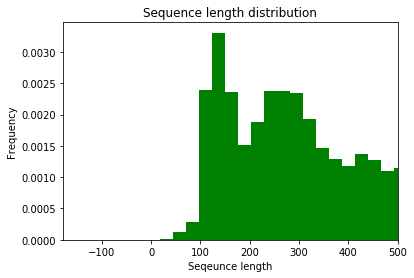

In [22]:
import matplotlib.pyplot as plt
plt.hist(length, bins='auto',density=True, facecolor='g')
plt.xlabel('Seqeunce length')
plt.gca().set_xlim(right=500)
plt.ylabel('Frequency')
plt.title('Sequence length distribution')
plt.show()

In [10]:
###CNN Autoencoder
x_data, _ = load_dataset("example/sprot_dna_tf_pfam.tsv")
x_data = preprocess_dataset(x_data, padded=not False)
train_x = x_data
#split_size = int(train_x.shape[0]*0.7)
#train_x, val_x = train_x[:split_size], train_x[split_size:]
#print(x_data[0].shape)
input_shape = x_data[0].shape

input_seq = Input(shape=input_shape, name='aa_seq')
print('The input data format{0}'.format(input_seq.get_shape()))
#x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
x = Convolution1D(filters=400,kernel_size=50,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv1')(input_seq)
print("The Conv1 data format{0}".format(x.get_shape()))
x = Convolution1D(filters=400,kernel_size=100,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv2')(x)
print("The Conv2 data format{0}".format(x.get_shape()))
#conv2DShape = x.get_shape[1]
#x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)
shape_before_flattening = K.int_shape(x)
pool = GlobalMaxPooling1D()(x)#Give the size of the filter
print("The Pool data format{0}".format(pool.get_shape()))
#x = Flatten()(x)
#x = Dense(units=filters[2], name='Dense1')(pool)
encoded = Dense(units=400, activation='sigmoid',name='embedding')(pool)
print("The Dense data format{0}".format(encoded.get_shape()))
#x = Dense(units=filters[3], activation='relu')(encoded)

print((shape_before_flattening[2:]))
# Decoder
x = Dense(np.prod(shape_before_flattening[2:]),activation='relu')(encoded)
print("The DeDense data format{0}".format(x.get_shape()))
#x = Reshape((1,400))(x)
x = Reshape((1,np.prod(shape_before_flattening[2:])))(x)
print("The Reshape data format{0}".format(x.get_shape()))
x = UpSampling1D(1439)(x)
print("The UpSamplingCov2 data format{0}".format(x.get_shape()))
#print("The UpSamplingCov2 data format{0}".format(x.get_shape()))
x = Convolution1D(filters=400,kernel_size=50, activation='relu', padding='same')(x)
print("The DeCov2 data format{0}".format(x.get_shape()))
#x = UpSampling1D()(x)
#x = Convolution1D(8, (3, 3), activation='relu', padding='same')(x)
#x = Convolution1D(16, (3, 3), activation='relu')(x)
#x = UpSampling2D((1))(x)
decoded = Convolution1D(filters=20,kernel_size=50, activation='softmax', padding='same')(x)
print(decoded.get_shape())
    
autoencoder = Model(inputs=input_seq, outputs=decoded, name='AE')
encoder = Model(inputs=input_seq, outputs=encoded, name='encoder')


Dataset size: 11036
The input data format(?, 1439, 20)
The Conv1 data format(?, 1439, 400)
The Conv2 data format(?, 1439, 400)
The Pool data format(?, 400)
The Dense data format(?, 400)
(400,)
The DeDense data format(?, 400)
The Reshape data format(?, 1, 400)
The UpSamplingCov2 data format(?, 1439, 400)
The DeCov2 data format(?, 1439, 400)
(?, 1439, 20)


In [6]:
#t = train_x.reshape((train_x.shape[0], -1))
#t.shape
#mean_cat_acc(x_data[0],x_data[1])

<tf.Tensor 'div:0' shape=() dtype=float32>

In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aa_seq (InputLayer)          (None, 1439, 20)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1439, 400)         400000    
_________________________________________________________________
Conv2 (Conv1D)               (None, 1439, 400)         16000000  
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 400)               0         
_________________________________________________________________
embedding (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 400)            0         
__________

In [12]:
autoencoder.compile(optimizer='nadam', loss=[multiclass_categorical_crossentropy],metrics=[mean_cat_acc])

In [13]:
train_history = autoencoder.fit(train_x, train_x, epochs=10, batch_size=50, validation_split=0.20)

Train on 8828 samples, validate on 2208 samples
Epoch 1/10
8828/8828 [==============================] - 88s 10ms/step - loss: 15.7286 - mean_cat_acc: 0.0925 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 2/10
8828/8828 [==============================] - 79s 9ms/step - loss: 15.7275 - mean_cat_acc: 0.0930 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 3/10
8828/8828 [==============================] - 79s 9ms/step - loss: 15.7275 - mean_cat_acc: 0.0929 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 4/10
8828/8828 [==============================] - 79s 9ms/step - loss: 15.7275 - mean_cat_acc: 0.0929 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 5/10
8828/8828 [==============================] - 79s 9ms/step - loss: 15.7275 - mean_cat_acc: 0.0930 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 6/10
8828/8828 [==============================] - 79s 9ms/step - loss: 15.7275 - mean_cat_acc: 0.0929 - val_loss: 15.7308 - val_mean_cat_acc: 0.0876
Epoch 7/10
8828/8828 

In [20]:
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20)
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)
km.fit(pred_auto_train)
pred = km.predict(pred_auto)
normalized_mutual_info_score(val_y, pred)

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6795889475785513

In [78]:
pred_auto.shape

(21000, 10)

In [19]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')

def autoencoderConv2D_1(input_shape=(1590, 20), filters=[400,800,400,400]):
    
    input_seq = Input(shape=input_shape)
    
    #if input_shape[0] % 8 == 0:
    #    pad3 = 'same'
    #else:
    #    pad3 = 'valid'
    
    #x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Convolution1D(filters=filters[0],kernel_size=50,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv1')(input_seq)
    x = Convolution1D(filters=filters[1],kernel_size=50,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv2')(x)

    #x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)
    x = Flatten()(x)
    x = Dense(units=filters[2], name='Dense1')(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[3], activation='relu')(encoded)
    x = Dense(units=filters[2], activation='relu')(x)
    
    x = Reshape((1,400))(x)
    
    #Maybe use the UpSampling1D and Conv1D
    
    #x = Reshape((-1,1,20))(x)
    
    #x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    #x = Conv2DTranspose(filters=20, kernel_size = (50,1),strides=1, padding='same', activation='relu', name='deconv2')(x)

    #decoded = Conv2DTranspose(input_shape[1], kernel_size = (50,1), strides=1, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_seq, outputs=decoded, name='AE'), Model(inputs=input_seq, outputs=encoded, name='encoder')

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)
        #print(self.input_dim)
        #self.autoencoder, self.encoder = autoencoderConv2D_1(self.input_dim)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    #print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                    #      % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (accuracy_score(self.y, y_pred), normalized_mutual_info_score(self.y, y_pred)))
                    

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(accuracy_score(y, y_pred), 5)
                    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
                    ari = np.round(normalized_mutual_info_score(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [20]:
# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.001
save_dir = 'results'

x_data, _ = load_dataset("example/IGC.DOI.tsv")
x_data = preprocess_dataset(x_data, padded=not False)
train_x = x_data
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
#train_x = np.concatenate((x_train, x_test))
#train_y = np.concatenate((y_train, y_test))

#train_x = train_x.reshape((train_x.shape[0], -1))
#train_x = np.divide(train_x, 255.)

#split_size = int(train_x.shape[0]*0.85)
#train_x, val_x = train_x[:split_size,], train_x[split_size:,]
#train_y,val_y = train_y[:split_size], train_y[split_size:]



if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 100
init = VarianceScaling(scale=1. / 3., mode='fan_in',distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[(1189,20),400,800,400,400], n_clusters=12, init=init)

Dataset size: 13434
(1189, 20)


In [22]:
dec.pretrain(x=train_x, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...


ValueError: Error when checking target: expected deconv1 to have 4 dimensions, but got array with shape (13434, 1189, 20)

In [139]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 12)                120       
Total params: 1,665,130
Trainable params: 1,665,130
Non-trainable params: 0
_________________________________________________________________


In [140]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec.fit(train_x,train_y,tol=tol, maxiter=maxiter, batch_size=batch_size,update_interval=update_interval, save_dir=save_dir)
pred_val = dec.predict(val_x)
normalized_mutual_info_score(val_y, pred_val)

('Update interval', 200)
('Save interval', 145)
Initializing cluster centers with k-means.
('Iter 0: acc = 0.10489, nmi = 0.73327, ari = 0.73327', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_0.h5')
('saving model to:', 'results/DEC_model_145.h5')
('Iter 200: acc = 0.10365, nmi = 0.74296, ari = 0.74296', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_290.h5')
('Iter 400: acc = 0.10309, nmi = 0.74699, ari = 0.74699', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_435.h5')
('saving model to:', 'results/DEC_model_580.h5')
('Iter 600: acc = 0.10250, nmi = 0.75493, ari = 0.75493', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_725.h5')
('Iter 800: acc = 0.10166, nmi = 0.76255, ari = 0.76255', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_870.h5')
('Iter 1000: acc = 0.10168, nmi = 0.76847, ari = 0.76847', ' ; loss=', 0)
('saving model to:', 'results/DEC_model_1015.h5')
('saving model to:', 'results/DEC_model_1160.h5')
('Iter 1200: acc = 0.10128, nmi

0.809492606873538

In [142]:
accuracy_score(val_y, pred_val)
(val_y)[1:10]

array([4, 5, 6, 7, 8, 9, 5, 6, 6], dtype=uint8)

In [143]:
(pred_val)[1:10]

array([11,  7,  8,  5,  6,  0,  7,  8,  8])

In [123]:
train_x[:5000,].shape

(5000, 784)

In [ ]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


In [ ]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

def autoencoderConv2D_1(input_shape=(1590, 20), filters=[400,800,400,400]):
    
    input_seq = Input(shape=input_shape)
    
    #if input_shape[0] % 8 == 0:
    #    pad3 = 'same'
    #else:
    #    pad3 = 'valid'
    
    #x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Convolution1D(filters=filters[0],kernel_size=50,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv1')(input_seq)
    x = Convolution1D(filters=filters[1],kernel_size=50,strides=1,padding='same',use_bias=False,kernel_initializer='glorot_uniform',activation='relu',name='Conv2')(x)

    #x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)
    x = Flatten()(x)
    x = Dense(units=filters[2], name='embedding')(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[3], activation='relu')(encoded)
    x = Dense(units=filters[2], activation='relu')(x)
    
    x = Reshape((1,400))(x)
    
    x = Reshape((-1,1,20))(x)
    
    #x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters=20, kernel_size = (50,1),strides=1, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[1], kernel_size = (50,1), strides=1, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_seq, outputs=decoded, name='AE'), Model(inputs=input_seq, outputs=encoded, name='encoder')

In [1]:
filters=[32, 64, 128, 10]
filters[-1]

10

In [2]:
range(3-1, 0, -1)

[2, 1]